## Maps of Beaufort lead fraction 

In [1]:
#!pip install --target=/home/rheinlender/notebooks/beaufort-breakup-nextsimOPA/main ../.
import sys 
sys.path.append('../src')

In [2]:
# read moorings 
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from pynextsim.projection_info import ProjectionInfo
from brkup_utils import lead_detect as lead_det
from brkup_utils import process_data
from brkup_utils import mask_funcs as msk
from brkup_utils.boxnames import *
import datetime as dt
import pandas as pd
import matplotlib.gridspec as gridspec


In [3]:
BOXNAMES

{'Beaufort': (95, 225, 425, 575), 'Large_Arctic': (0, 528, 0, 603)}

In [4]:
# pick date to plot

dto = dt.datetime(2013,3,1)
#dto = dt.datetime(2016,3,25)
datestring=str(dto.strftime('%Y-%m-%d'))

yy = dto.year
mm = dto.month

if mm<10:
    months=[f'0{mm}']
else:
    months=[f'{mm}']

years = [yy]


In [5]:
# read moorings 
indir = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/' 

# subset Beaufort Sea
ds = process_data.load_moorings(indir,months,years,region=None ,period=None)

# daily average
ds.coords['time'] = ds.time.dt.floor('1D')
ds = ds.groupby('time').mean()
# Drop time dimension - lon lat should be 2D 
ds['longitude'] = ds.longitude.isel(time=0, drop=True)
ds['latitude'] = ds.latitude.isel(time=0, drop=True)

months: ['03']
years: [2013]
DONE!


In [6]:
# calculate lead fraction
clim=0.05
leadfrac, leadmask = lead_det.map_leads(ds, 'breakup_paper', clim)

# daily lead area frac in Beaufort Sea
bbox = BOXNAMES['Beaufort']
Mask = msk.Masking(ds)
msk_moore2022 = Mask.get_Moore2022_Beaufort_mask()

lfa = leadmask.where(msk_moore2022).mean(dim=('x', 'y'))

print(f'LAF on {datestring}:  {lfa.sel(time=datestring).values}')


LAF on 2013-03-01:  0.26022207707380796


# Plot Figure 1

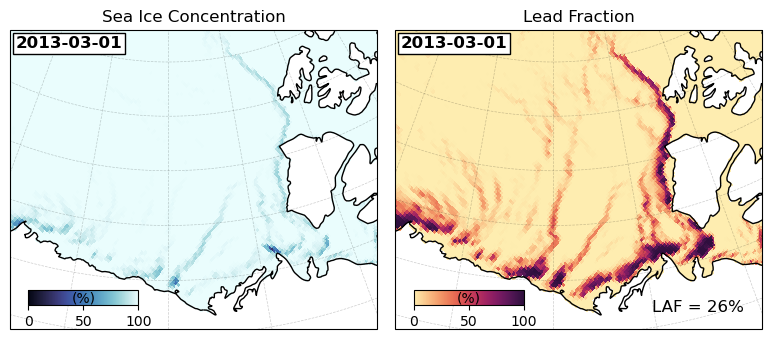

In [7]:
# prepare the plot

# get lon/lat from model
lon = ds['longitude'][:].values
lat = ds['latitude'][:].values

plot_crs = ccrs.NorthPolarStereo(central_longitude=-140, true_scale_latitude=60)
xy = plot_crs.transform_points(ccrs.PlateCarree(), lon, lat)
x = xy[:,:,0]
y = xy[:,:,1]

#new_cmap = truncate_colormap(cmap, 0.2, 1, n=4)

kw1 = {'cmap': cmocean.cm.ice,
        'zorder':0,
        #'levels': np.arange(0,1, 0.1)
        'vmin':0,
        'vmax':100,
       }

kw2 = {'cmap': cmocean.cm.matter,
        'zorder':0,
        #'levels': np.arange(0,1, 0.1)
        'vmin':0,
        'vmax':100,
       }

plotvars = (ds['sic'].sel(time=datestring)*100, leadfrac.sel(time=datestring)*100)

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 2, left=0.01, right=0.95, wspace=0.05, hspace=0.05)
ax1 = fig.add_subplot(gs[:, 0], projection= plot_crs)
ax2 = fig.add_subplot(gs[:, 1], projection= plot_crs)

for var, ax, kw_c in zip(plotvars, (ax1,ax2), (kw1, kw2)):
    
    # Set axes prop
    ax.set_extent([-155, -120, 67.5, 78.5], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, edgecolor='black', zorder=1, alpha=0)
    ax.coastlines(resolution="50m",linewidth=1)

    # Add gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=0.5, color='black', linestyle='--', alpha=0.2)
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = False
    gl.left_labels = False
    #gl.xlines = False

    ax.text(.015, .98, datestring, ha='left', va='top', transform=ax.transAxes, fontsize=12, fontweight='bold', 
               bbox=dict(facecolor='white', edgecolor='black', pad=2.0))

    c = ax.pcolormesh(x, y, var, transform=plot_crs, **kw_c )

    cax = ax.inset_axes([0.05, 0.08, 0.3, 0.05])
    cb = fig.colorbar(c, ax=ax, cax=cax, orientation="horizontal")
    cb.set_label('(%)', rotation=0, y=1.2, labelpad=-27)

ax1.set_title('Sea Ice Concentration')
ax2.set_title('Lead Fraction')

lfa_at_dto = lfa.sel(time=datestring).values*100
lfa_label = "LAF = {:.0f}%".format(lfa_at_dto)
ax2.text(.7, .1, lfa_label, ha='left', va='top', transform=ax2.transAxes, fontsize=12, fontweight='normal')


fig.savefig('../figures/' + f'fig01_map_leadAreaFrac_SIC_BS_{datestring}.png', dpi=300, bbox_inches='tight')    
